# Simple CNN with **Keras** — MNIST Example

This notebook shows how to build, train, and evaluate a **Convolutional Neural Network (CNN)** using the **Keras** high-level API.
We will use the classic **MNIST** handwritten digits dataset.

**Highlights**
- Keras-first imports (`from keras import layers, models`)
- Minimal Sequential CNN: `Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense`
- Clear, line-by-line comments explaining what each statement does
- Simple plots for training curves and sample predictions


In [1]:
!pip install keras

In [2]:
!pip install matplotlib

In [3]:
!pip install keras tensorflow

In [4]:
# --- Imports (Keras-first) ---
# Keras is a high-level deep learning API.
# In Keras 3, the backend (TensorFlow/JAX/PyTorch) is selected via environment variable KERAS_BACKEND.
# If none is set, it tries TensorFlow by default if available.
import keras                                  # Keras main package
from keras import layers, models, optimizers, losses, metrics  # Common Keras primitives
from keras.datasets import mnist               # Built-in MNIST dataset loader

import numpy as np                             # Numerical operations
import matplotlib.pyplot as plt                # Plotting training curves and images

# Optional: display which backend Keras is using (TF/JAX/PyTorch)
try:
    backend_name = keras.config.backend()      # Keras 3 API to check backend
except Exception:
    # Fallback for older versions
    import keras.backend as K
    backend_name = getattr(K, 'backend', lambda: 'unknown')()
print('Keras backend:', backend_name)

# Make runs deterministic (helps reproducibility, though exact repeatability is not guaranteed across backends/hardware)
np.random.seed(42)


2025-11-09 15:56:33.065310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras backend: tensorflow


In [5]:
# --- Load and preprocess MNIST ---
# mnist.load_data() returns:
#   (x_train, y_train): 60,000 training images/labels
#   (x_test, y_test):   10,000 test images/labels
# Each image is 28x28 grayscale (uint8 0..255)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Raw x_train shape:', x_train.shape)  # (60000, 28, 28)
print('Raw y_train shape:', y_train.shape)  # (60000,)

# Convert images to float32 and normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Add a channel dimension so the shape becomes (N, 28, 28, 1)
# CNNs expect channels-last by default for Keras on TF backend.
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis=-1)   # (10000, 28, 28, 1)

print('Prepared x_train shape:', x_train.shape)
print('Prepared x_test shape:', x_test.shape)


Raw x_train shape: (60000, 28, 28)
Raw y_train shape: (60000,)
Prepared x_train shape: (60000, 28, 28, 1)
Prepared x_test shape: (10000, 28, 28, 1)


In [6]:
# --- Build a simple Keras Sequential CNN ---
# We stack layers in order using the Sequential API.
model = models.Sequential([
    # First convolutional block:
    # - Conv2D extracts local patterns with learnable filters (kernels).
    # - activation='relu' adds nonlinearity.
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name='conv1'),
    # Downsample with max pooling to reduce spatial size and computation, and add some invariance.
    layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),

    # Second convolutional block:
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),

    # Flatten 2D feature maps to 1D so we can use Dense (fully-connected) layers.
    layers.Flatten(name='flatten'),

    # Dense layer to mix features; 128 units is a common small setting for MNIST.
    layers.Dense(128, activation='relu', name='dense1'),

    # Output layer with 10 units (digits 0-9). Softmax converts logits to probabilities.
    layers.Dense(10, activation='softmax', name='predictions'),
])

# Print a summary to inspect the architecture and parameter counts.
model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# --- Compile the model ---
# We specify:
#   - optimizer: how gradients update weights (Adam is a robust default)
#   - loss: what we minimize (Sparse Categorical Crossentropy fits integer class labels)
#   - metrics: what to report (accuracy is intuitive for classification)
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)


In [8]:
# --- Train the model ---
# Fit for a few epochs for a quick demo; increase epochs for higher accuracy.
history = model.fit(
    x_train, y_train,
    epochs=5,            # try 10+ for better results
    batch_size=128,      # number of samples per gradient update
    validation_split=0.1,# hold out 10% of training data for validation
    verbose=2            # print one line per epoch
)


Epoch 1/5
422/422 - 39s - 93ms/step - loss: 0.2306 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.0676 - val_sparse_categorical_accuracy: 0.9795
Epoch 2/5
422/422 - 40s - 94ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.0503 - val_sparse_categorical_accuracy: 0.9882
Epoch 3/5
422/422 - 56s - 132ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.0423 - val_sparse_categorical_accuracy: 0.9883
Epoch 4/5
422/422 - 55s - 131ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.0403 - val_sparse_categorical_accuracy: 0.9888
Epoch 5/5
422/422 - 54s - 127ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0359 - val_sparse_categorical_accuracy: 0.9905


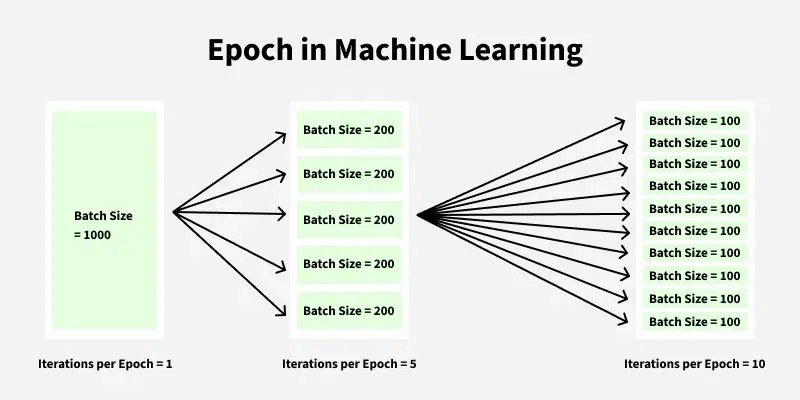

In [9]:
# --- Evaluate on the test set ---
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


Test loss: 0.0333
Test accuracy: 0.9887


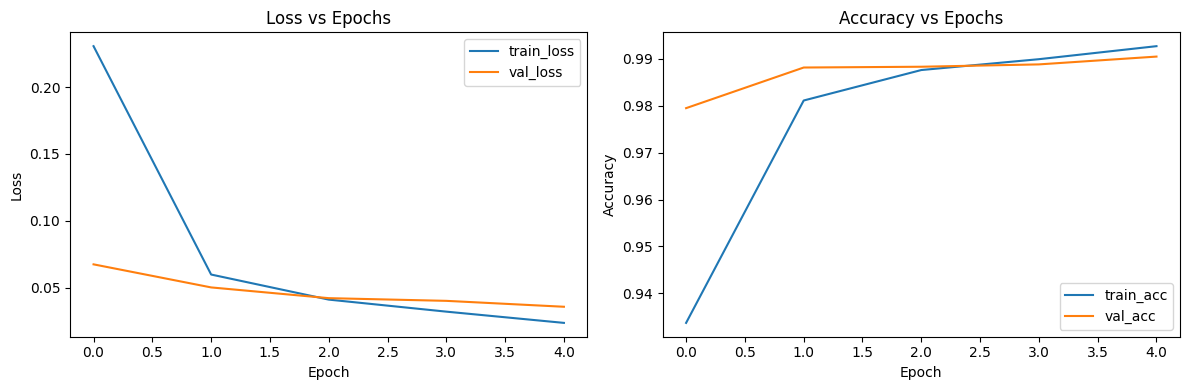

In [10]:
# --- Plot training curves ---
# We visualize loss and accuracy for both training and validation sets across epochs.
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='train_acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


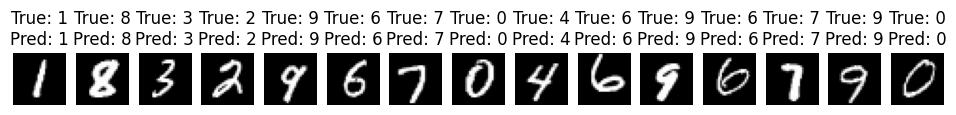

In [13]:
# --- Visualize a few predictions ---
# Randomly pick a few test images, predict their labels, and plot them.
num_images = 15
indices = np.random.choice(len(x_test), num_images, replace=False)

# Predict class probabilities for the selected images
probs = model.predict(x_test[indices], verbose=0)
predictions = probs.argmax(axis=1)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[idx]}\nPred: {predictions[i]}")
    plt.axis('off')
plt.show()
